In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

## 1) Data Preparation

In [2]:
col_names = [
    'age',
    'workclass', #(eg. private, local-gov, never-worked…)
    'fnlwgt', #(the number of people the census believes the entry represents)
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native country',
    'label' 
    ]

In [3]:
df_full_train = pd.read_csv('./data/adult.data',names=col_names)
df_full_test = pd.read_csv('./data/adult.test',names=col_names)

In [4]:
df_full_test = df_full_test.iloc[1:].reset_index(drop=True)

In [5]:
categorical_columns = list(df_full_train.dtypes[df_full_train.dtypes == 'object'].index)

for c in categorical_columns:
    df_full_train[c] = df_full_train[c].str.lower().str.replace(' ', '_')
    df_full_test[c] = df_full_test[c].str.lower().str.replace(' ', '_')

In [6]:
df_full_train['label'] = df_full_train['label'].map({'_<=50k':0, '_>50k':1})
df_full_train = df_full_train.rename({'label': 'income_over_50k'}, axis=1) 

In [7]:
df_full_test['label'] = df_full_test['label'].map({'_<=50k.':0, '_>50k.':1})
df_full_test = df_full_test.rename({'label': 'income_over_50k'}, axis=1) 

## 2) Validation Framework

In [8]:
df_val, df_test = train_test_split(df_full_test, test_size=0.5, random_state=1)

In [9]:
len(df_full_train), len(df_val), len(df_test)

(32561, 8140, 8141)

In [10]:
df_train = df_full_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
y_train = df_train.income_over_50k.values
y_val = df_val.income_over_50k.values
y_test = df_test.income_over_50k.values

del df_train['income_over_50k']
del df_val['income_over_50k']
del df_test['income_over_50k']


## 3) EDA
- Missing values
- Target values distribution
- Numerical features distributions
- Categorical features distributions

In [12]:
df_full_train.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native country     0
income_over_50k    0
dtype: int64

In [13]:
df_full_train['income_over_50k'].value_counts(normalize=True)

0    0.75919
1    0.24081
Name: income_over_50k, dtype: float64

In [14]:
df_full_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native country',
       'income_over_50k'],
      dtype='object')

In [15]:
numerical = ['age', 
             'fnlwgt', 
             'education-num',
             'capital-gain',
             'capital-loss',
             'hours-per-week' 
            ]

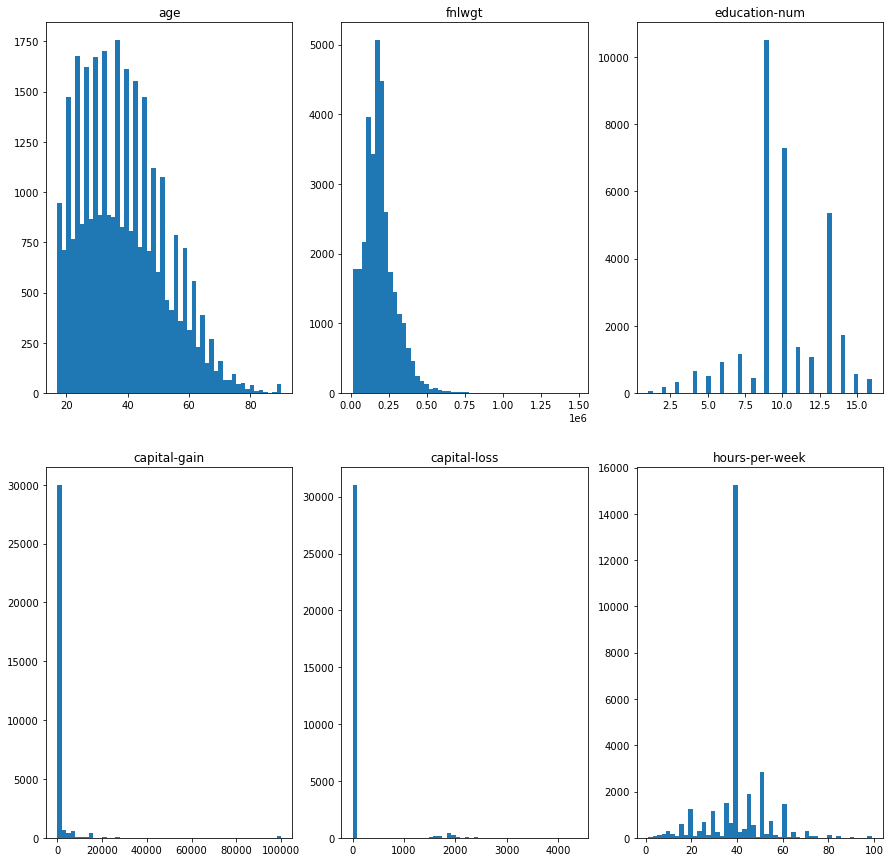

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

axes_ = ax1, ax2, ax3, ax4, ax5, ax6

for ax, feature in zip(axes_ , numerical):
    
    ax.hist(df_full_train[feature], bins = 50)    
    ax.set_title(feature)

plt.show()

In [17]:
categorical = ['workclass', 
               'education', 
               'marital-status', 
               'occupation',
               'relationship', 
               'race', 
               'sex', 
               'native country'
              ]

In [18]:
df_full_train[categorical].nunique()

workclass          9
education         16
marital-status     7
occupation        15
relationship       6
race               5
sex                2
native country    42
dtype: int64

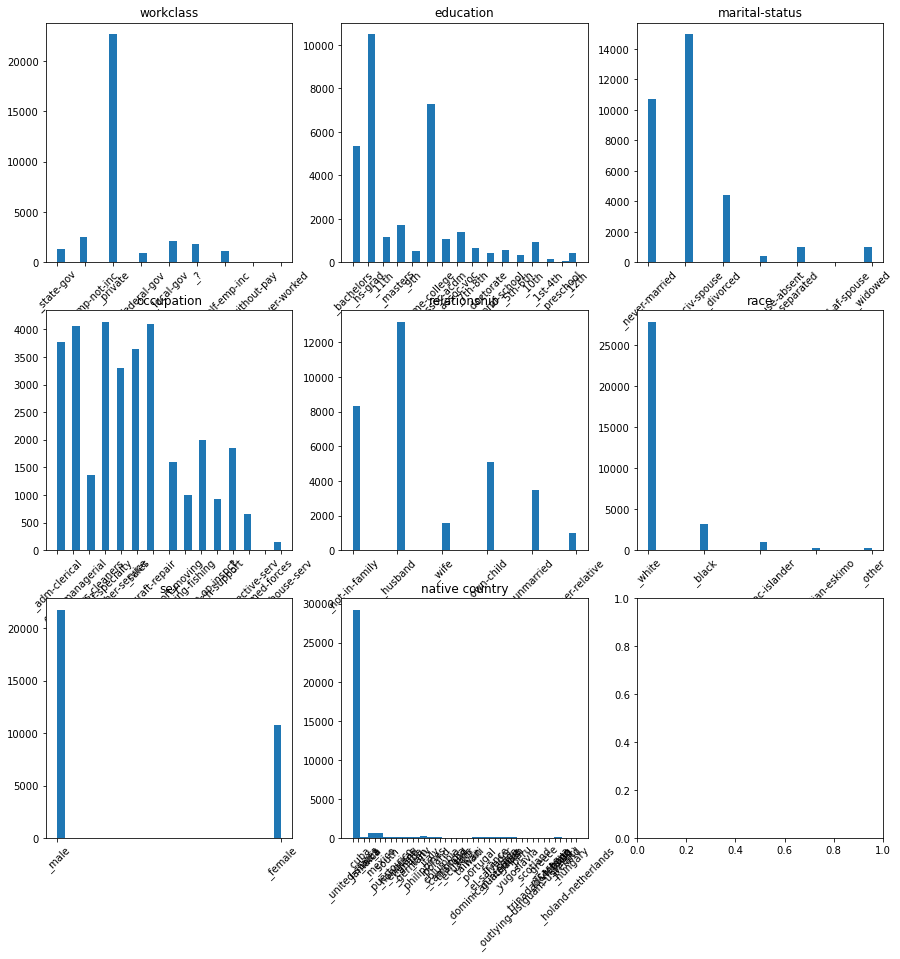

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

axes_ = ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8

for ax, feature in zip(axes_ , categorical):
    
    ax.hist(df_full_train[feature],bins=30)    
    ax.set_title(feature)
    ax.tick_params(axis='x', labelrotation=45)
    # ax.set_xticklabels(rotation=45, ha='right')

plt.show()

## 4) Feature importance
- High income rate (rate of incomes over 50k)
- High income probability ratio
- Mutual Information
- Correlation

In [20]:
global_high_income_rate = df_full_train.income_over_50k.mean()
global_high_income_rate

0.2408095574460244

In [21]:
high_income_male = df_full_train[df_full_train.sex == '_male'].income_over_50k.mean()
high_income_male

0.3057365764111978

In [22]:
high_income_female = df_full_train[df_full_train.sex == '_female'].income_over_50k.mean()
high_income_female

0.10946058861758426

In [23]:
global_high_income_rate - high_income_male

-0.06492701896517339

In [24]:
global_high_income_rate - high_income_female

0.13134896882844013

In [25]:
high_income_male / global_high_income_rate

1.2696197761159305

In [26]:
high_income_female / global_high_income_rate

0.4545525093708916

In [27]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).income_over_50k.agg(['mean', 'count'])
    df_group['high_income_probability_difference'] = df_group['mean'] - global_high_income_rate
    df_group['high_income_probability_ratio'] = df_group['mean'] / global_high_income_rate
    display(df_group)
    print()
    print()

workclass


,mean,count,high_income_probability_difference,high_income_probability_ratio
workclass,,,,
_?,0.104031,1836,-0.136779,0.432003
_federal-gov,0.386458,960,0.145649,1.604830
_local-gov,0.294792,2093,0.053983,1.224171
_never-worked,0.000000,7,-0.240810,0.000000
_private,0.218673,22696,-0.022137,0.908074
_self-emp-inc,0.557348,1116,0.316538,2.314475
_self-emp-not-inc,0.284927,2541,0.044118,1.183206
_state-gov,0.271957,1298,0.031147,1.129344
_without-pay,0.000000,14,-0.240810,0.000000




education


,mean,count,high_income_probability_difference,high_income_probability_ratio
education,,,,
_10th,0.066452,933,-0.174357,0.275954
_11th,0.051064,1175,-0.189746,0.212051
_12th,0.076212,433,-0.164597,0.316484
_1st-4th,0.035714,168,-0.205095,0.148309
_5th-6th,0.048048,333,-0.192762,0.199527
_7th-8th,0.061920,646,-0.178890,0.257131
_9th,0.052529,514,-0.188280,0.218136
_assoc-acdm,0.248360,1067,0.007550,1.031354
_assoc-voc,0.261216,1382,0.020406,1.084739




marital-status


,mean,count,high_income_probability_difference,high_income_probability_ratio
marital-status,,,,
_divorced,0.104209,4443,-0.136601,0.432744
_married-af-spouse,0.434783,23,0.193973,1.805504
_married-civ-spouse,0.446848,14976,0.206039,1.855609
_married-spouse-absent,0.081340,418,-0.159470,0.337776
_never-married,0.045961,10683,-0.194849,0.190860
_separated,0.064390,1025,-0.176419,0.267391
_widowed,0.085599,993,-0.155210,0.355464




occupation


,mean,count,high_income_probability_difference,high_income_probability_ratio
occupation,,,,
_?,0.103635,1843,-0.137174,0.430362
_adm-clerical,0.134483,3770,-0.106327,0.558461
_armed-forces,0.111111,9,-0.129698,0.461407
_craft-repair,0.226641,4099,-0.014169,0.941161
_exec-managerial,0.484014,4066,0.243204,2.009944
_farming-fishing,0.115694,994,-0.125115,0.480438
_handlers-cleaners,0.062774,1370,-0.178036,0.260678
_machine-op-inspct,0.124875,2002,-0.115934,0.518564
_other-service,0.041578,3295,-0.199231,0.172660




relationship


,mean,count,high_income_probability_difference,high_income_probability_ratio
relationship,,,,
_husband,0.448571,13193,0.207762,1.862763
_not-in-family,0.103070,8305,-0.137739,0.428016
_other-relative,0.037717,981,-0.203093,0.156624
_own-child,0.013220,5068,-0.227589,0.054899
_unmarried,0.063262,3446,-0.177548,0.262704
_wife,0.475128,1568,0.234318,1.973043




race


,mean,count,high_income_probability_difference,high_income_probability_ratio
race,,,,
_amer-indian-eskimo,0.115756,311,-0.125054,0.480694
_asian-pac-islander,0.265640,1039,0.024830,1.103113
_black,0.123880,3124,-0.116930,0.514430
_other,0.092251,271,-0.148559,0.383087
_white,0.255860,27816,0.015050,1.062499




sex


,mean,count,high_income_probability_difference,high_income_probability_ratio
sex,,,,
_female,0.109461,10771,-0.131349,0.454553
_male,0.305737,21790,0.064927,1.269620




native country


,mean,count,high_income_probability_difference,high_income_probability_ratio
native country,,,,
_?,0.250429,583,0.009619,1.039946
_cambodia,0.368421,19,0.127611,1.529927
_canada,0.322314,121,0.081504,1.338460
_china,0.266667,75,0.025857,1.107376
_columbia,0.033898,59,-0.206911,0.140768
_cuba,0.263158,95,0.022348,1.092805
_dominican-republic,0.028571,70,-0.212238,0.118647
_ecuador,0.142857,28,-0.097952,0.593237
_el-salvador,0.084906,106,-0.155904,0.352584


In [28]:
for  c in categorical:
    print (c)
    print(mutual_info_score(df_full_train[c], df_full_train['income_over_50k']))
    print()

workclass
0.014952286926024641

education
0.064872227626807

marital-status
0.10849684839091919

occupation
0.06440895776401497

relationship
0.11462280890861032

race
0.005807149876488754

sex
0.025765242400373284

native country
0.006027151805763077



In [29]:
df_full_train[numerical].corrwith(df_full_train.income_over_50k).abs()

age               0.234037
fnlwgt            0.009463
education-num     0.335154
capital-gain      0.223329
capital-loss      0.150526
hours-per-week    0.229689
dtype: float64

## 5) One-hot encoding

In [47]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

## 6) Baseline

In [48]:
len(y_train), len(y_val), len(y_test)

(32561, 8140, 8141)

In [49]:
y_pred_baseline = np.zeros(8140)

In [50]:
roc_auc_score(y_val, y_pred_baseline)

0.5

## 6) Logistic regression

In [51]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [52]:
y_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

In [53]:
roc_auc_score(y_val, y_pred), roc_auc_score(y_test, y_test_pred)

(0.6133603269701364, 0.6107273002398783)

## 7) Desicion tree classifier

In [88]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [92]:
y_pred = dt.predict_proba(X_val)[:, 1]
y_test_pred = dt.predict_proba(X_test)[:, 1]

In [93]:
roc_auc_score(y_val, y_pred), roc_auc_score(y_test, y_test_pred)

(0.6387368250733972, 0.6425494247798221)

In [97]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.758
   2 -> 0.834
   3 -> 0.820
   4 -> 0.833
   5 -> 0.835
   6 -> 0.837
  10 -> 0.779
  15 -> 0.671
  20 -> 0.639
None -> 0.638


In [98]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [99]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [100]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.833  0.835  0.837
5                 0.863  0.866  0.868
10                0.874  0.876  0.879
15                0.876  0.878  0.879
20                0.876  0.878  0.879
100               0.877  0.876  0.876
200               0.877  0.876  0.878
500               0.874  0.873  0.869

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

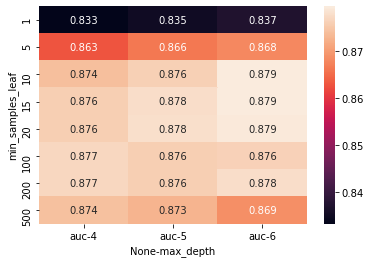

In [101]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [102]:
dt_final = DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)

In [105]:
y_pred = dt_final.predict_proba(X_val)[:, 1]
y_test_pred = dt_final.predict_proba(X_test)[:, 1]

In [106]:
roc_auc_score(y_val, y_pred), roc_auc_score(y_test, y_test_pred)

(0.8791063682828067, 0.8804750517421156)

## 8) Random forest classifier

In [109]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [110]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

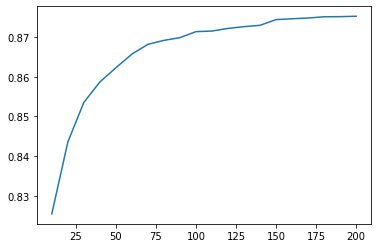

In [111]:
plt.plot(df_scores.n_estimators, df_scores.auc)